In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from NEExT import NEExT

%reload_ext autoreload
%autoreload 2

In [2]:
edge_file_path = "../data/ABCDO-full/edges.csv"
node_graph_mapping_file_path = "../data/ABCDO-full/graph_mapping.csv"
features_file_path = "../data/ABCDO-full/features.csv"

edges = pd.read_csv(edge_file_path)
mapping = pd.read_csv(node_graph_mapping_file_path)
_features = pd.read_csv(features_file_path)

In [3]:
import os

def semi_supervised_set(df, col="is_outlier", hide_frac={0: 0.1, 1: 0.1}, seed=42):
    np.random.seed(seed)

    for _cls, frac in hide_frac.items():
        mask = df[col] == _cls  
        drop_indices = np.random.choice(df[mask].index, size=int(len(df[mask]) * frac), replace=False)
        df.loc[drop_indices, col] = -1
    
    return df


_features = semi_supervised_set(_features)

edge_file_path = "../data/ABCDO-partial/edges.csv"
node_graph_mapping_file_path = "../data/ABCDO-partial/graph_mapping.csv"
features_file_path = "../data/ABCDO-partial/features.csv"

os.makedirs('../data/ABCDO-partial/', exist_ok=True)
edges.to_csv(edge_file_path, index=False)
mapping.to_csv(node_graph_mapping_file_path, index=False)
_features.to_csv(features_file_path, index=False)

In [4]:
from NEExT.collections import EgonetCollection
from NEExT.features import NodeFeatures, StructuralNodeFeatures
from NEExT.io import GraphIO
from NEExT.ml_models import MLModels

target = "is_outlier"
sample_size = 5

graph_io = GraphIO()
subgraph_collection = EgonetCollection()


graph_collection = graph_io.read_from_csv(
    edges_path=edge_file_path,
    node_graph_mapping_path=node_graph_mapping_file_path,
    node_features_path=features_file_path,
    graph_type="igraph",
)
subgraph_collection.create_egonets_from_graphs(
    graph_collection=graph_collection,
    egonet_target=target,
    egonet_algorithm="k_hop_egonet",
    skip_features=["community_id"],
    max_hop_length=1,
)

In [5]:
structural_node_features = StructuralNodeFeatures(
    graph_collection=subgraph_collection,
    feature_list=["all"],
    feature_vector_length=3,
    n_jobs=8,
)
node_features = NodeFeatures(
    subgraph_collection,
    feature_list=["random_community_feature"],
)

structural_features = structural_node_features.compute()
features = node_features.compute()

Computing structural node features:   0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
from NEExT.builders import EmbeddingBuilder

for s in ["structural_embedding"]:
    emb_builder = EmbeddingBuilder(subgraph_collection, strategy=s, structural_features=structural_features, features=features,)
    embeddings = emb_builder.compute(10, 6)
    
    ml_models = MLModels(
        graph_collection=subgraph_collection,
        embedding=embeddings,   
        model_type='classifier',
    )

    # results = ml_models.compute()
    # print(s, f"Model trained with average accuracy: {np.mean(results['accuracy']):.4f}")

In [7]:
import logging
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from typing import Any, Dict, List, Literal, Optional, Union

import numpy as np
import pandas as pd
from pydantic import BaseModel, Field, validator
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from NEExT.collections import GraphCollection
from NEExT.embeddings import Embeddings

# Try to import XGBoost, but provide fallbacks if it fails
try:
    from xgboost import XGBClassifier, XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False

# Try to import SMOTE, but handle if it's not available
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    SMOTE_AVAILABLE = False

# Import sklearn models as fallbacks
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge


def _train_classifier_iteration(self, iteration_data: Dict[str, Any]) -> Dict[str, Any]:
        """Train and evaluate a classifier for a single iteration."""
        i = iteration_data['i']
        X = iteration_data['X']
        y = iteration_data['y']
        feature_cols = iteration_data['feature_cols']
        test_size = iteration_data['test_size']
        random_state = iteration_data['random_state'] + i
        balance_dataset = iteration_data['balance_dataset']
        num_classes = iteration_data['num_classes']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X[feature_cols], y, test_size=test_size, random_state=random_state,  shuffle=True,
        )
        
        # # Balance dataset if requested
        # if balance_dataset:
        #     from imblearn.over_sampling import SMOTE
        #     smote = SMOTE(random_state=random_state)
        #     X_train, y_train = smote.fit_resample(X_train, y_train)
        
        # Train model based on selected algorithm
        if self.config.model_name == "xgboost" and XGBOOST_AVAILABLE:
            model = XGBClassifier(random_state=random_state, n_jobs=1)
        else:
            model = RandomForestClassifier(
                n_estimators=100,
                random_state=random_state,
                n_jobs=1
            )
        from sklearn.semi_supervised import SelfTrainingClassifier
        model = SelfTrainingClassifier(model, max_iter=10)

        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Get feature importance if requested
        feature_importance = None
        if self.config.compute_feature_importance:
            if self.config.model_name == "xgboost" and XGBOOST_AVAILABLE:
                importance = model.feature_importances_
            else:
                importance = model.feature_importances_
            
            # Create feature importance ranking
            importance_dict = dict(zip(feature_cols, importance))
            sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
            feature_importance = {feat: rank for rank, (feat, _) in enumerate(sorted_features, 1)}
        
        # Return results
        return {
            'model': model,
            # these scores are useless here
            # 'accuracy': accuracy_score(y_test, y_pred),
            # 'recall': recall_score(y_test, y_pred, average='macro'),
            # 'precision': precision_score(y_test, y_pred, average='macro'),
            # 'f1_score': f1_score(y_test, y_pred, average='macro'),
            'feature_importance': feature_importance
        }

self = ml_models
feature_cols = [col for col in self.data_df.columns 
                       if col not in ["graph_id", "label", "encoded_label"]]

iteration_data = [
            {
                'i': i,
                'X': self.data_df,
                'y': self.data_df["encoded_label"],
                'feature_cols': feature_cols,
                'test_size': self.config.test_size,
                'random_state': self.config.random_state,
                'balance_dataset': self.config.balance_dataset,
                'num_classes': self.num_classes
            }
            for i in range(self.config.sample_size)
        ]
executor_class = ProcessPoolExecutor if self.config.parallel_backend == "process" else ThreadPoolExecutor
results = []

results = [_train_classifier_iteration(self, iteration) for iteration in iteration_data]
        
        
# Collect results
models = [r['model'] for r in results]
# accuracy_scores = [r['accuracy'] for r in results]
# recall_scores = [r['recall'] for r in results]
# precision_scores = [r['precision'] for r in results]
# f1_scores = [r['f1_score'] for r in results]

# Process feature importance if computed
feature_importance_df = None
if self.config.compute_feature_importance:
    # Collect all rankings
    all_rankings = []
    for r in results:
        all_rankings.append(r['feature_importance'])
    
    # Calculate average rank for each feature
    feature_ranks = {}
    for feature in feature_cols:
        ranks = [r[feature] for r in all_rankings]
        feature_ranks[feature] = np.mean(ranks)
    
    # Create sorted DataFrame
    feature_importance_df = pd.DataFrame({'average_rank': feature_ranks}).sort_values('average_rank')

# Return results with means and standard deviations
out= {
    "model_type": "classifier",
    # "accuracy": accuracy_scores,
    # "accuracy_mean": np.mean(accuracy_scores),
    # "accuracy_std": np.std(accuracy_scores),
    # "recall": recall_scores,
    # "recall_mean": np.mean(recall_scores),
    # "recall_std": np.std(recall_scores),
    # "precision": precision_scores,
    # "precision_mean": np.mean(precision_scores),
    # "precision_std": np.std(precision_scores),
    # "f1_score": f1_scores,
    # "f1_score_mean": np.mean(f1_scores),
    # "f1_score_std": np.std(f1_scores),
    "model": models[-1],
    "classes": [0, 1],
    "feature_columns": feature_cols,
    "feature_importance": feature_importance_df
}

In [8]:
df = ml_models.data_df[out['feature_columns']]

from sklearn.manifold import MDS

mds = MDS()
df_latent = mds.fit_transform(df)

In [9]:
color = {0:'blue', 1:'red', -1:'gray'}
labels = _features['is_outlier'].map(color)

In [10]:
model_labels = out['model'].predict(df)
model_labels = pd.Series(model_labels).map(color)

In [11]:
# model_labels

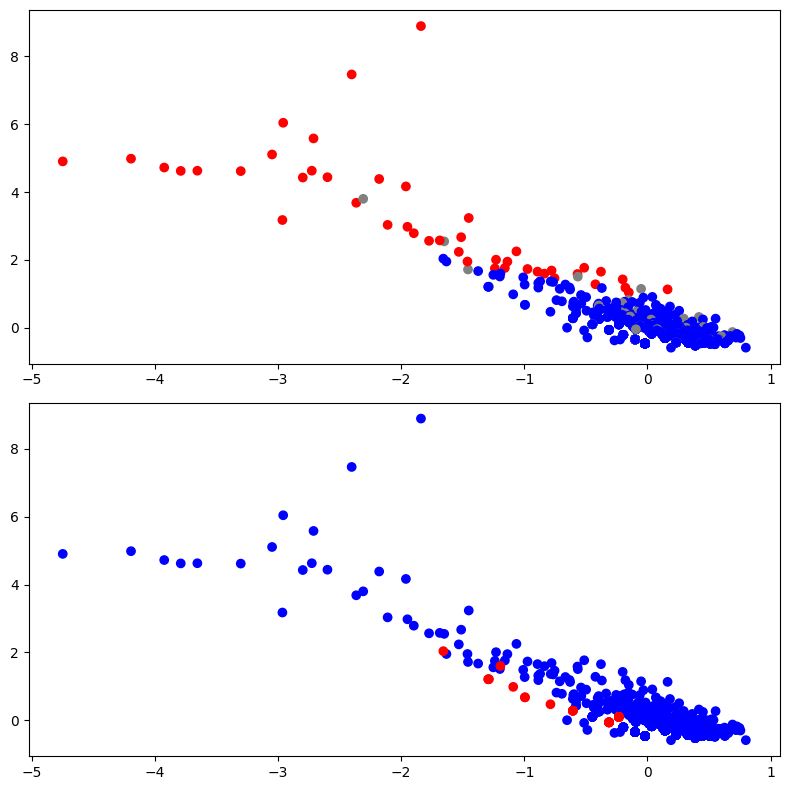

In [12]:

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].scatter(df_latent[:,0], df_latent[:,1], c=labels)
ax[1].scatter(df_latent[:,0], df_latent[:,1], c=model_labels)

fig.tight_layout()

In [26]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

df = ml_models.data_df

In [55]:
bots = df.query('encoded_label == 1')[out['feature_columns']]
vectors = df[out['feature_columns']].values
for bot in range(len(bots)):
    bot_vec = bots.values[bot, :]
    similarities = cosine_similarity(vectors, [bot_vec]).reshape(-1)
    
    if bot == 5:
        break

In [59]:
top_k = 5
ind = np.argpartition(similarities, -top_k)[-top_k:]
df.iloc[ind, :].sort_values('graph_id')

,graph_id,emb_0_struct,emb_1_struct,emb_2_struct,emb_3_struct,emb_4_struct,emb_5_struct,emb_6_struct,emb_7_struct,emb_8_struct,emb_9_struct,label,encoded_label
148,148,1.669163,-0.157003,-0.497266,0.103080,-0.074344,-0.242884,0.003057,-0.103822,0.059379,-0.072278,1.0,1.0
158,158,1.669163,-0.157003,-0.497266,0.103080,-0.074344,-0.242884,0.003057,-0.103822,0.059379,-0.072278,1.0,1.0
167,167,1.386099,-0.214718,-0.459254,0.068620,-0.035680,-0.191983,-0.003169,-0.079656,0.058702,-0.056671,1.0,1.0
198,198,1.129512,-0.260326,-0.416392,0.045661,0.002843,-0.146460,-0.008160,-0.057586,0.053894,-0.040717,1.0,1.0
227,227,1.129512,-0.260326,-0.416392,0.045661,0.002843,-0.146460,-0.008160,-0.057586,0.053894,-0.040717,0.0,0.0


In [58]:
features_file_path = "../data/ABCDO-full/features.csv"
_features = pd.read_csv(features_file_path)
# _features['is_outlier'][ind]
_features[_features.node_id.isin(ind)].sort_values('node_id')

,node_id,random_community_feature,community_id,is_outlier
5,148,41.758513,0,1
6,158,35.925781,0,1
7,167,49.391973,0,1
8,198,40.315927,0,1
75,227,25.565069,1,0


In [70]:
bots = df.query('encoded_label == -1')[out['feature_columns']]
graph_ids = df.query('encoded_label == -1')['graph_id']
vectors = df[out['feature_columns']].values
for bot, graph_id in zip(range(len(bots)), graph_ids):
    bot_vec = bots.values[bot, :]
    similarities = cosine_similarity(vectors, [bot_vec]).reshape(-1)
    
    if graph_id == 272:
        break

In [72]:
top_k = 10
ind = np.argpartition(similarities, -top_k)[-top_k:]
df.iloc[ind, :].sort_values('graph_id')['encoded_label']

239    1.0
244    0.0
245    0.0
269    0.0
272   -1.0
273   -1.0
287    0.0
295    1.0
300    0.0
303   -1.0
Name: encoded_label, dtype: float64

In [68]:
unknown_index = df.query('encoded_label == -1')['graph_id'].index

In [69]:
features_file_path = "../data/ABCDO-full/features.csv"
_features = pd.read_csv(features_file_path)
# _features['is_outlier'][ind]
_features[_features.node_id.isin(unknown_index)].sort_values('node_id')

,node_id,random_community_feature,community_id,is_outlier
686,5,14.591529,9,0
492,8,-27.706495,6,0
248,18,-34.722992,3,0
249,20,-32.137137,3,0
563,27,65.239510,7,0
...,...,...,...,...
413,958,-15.295397,4,0
620,961,59.498007,7,0
857,976,1.970740,11,0
743,982,14.769718,9,0


In [22]:
feature_cols = [col for col in self.data_df.columns 
                       if col not in ["graph_id", "label", "encoded_label"]]
        
y_pred = out['model'].predict(self.data_df[feature_cols])

In [23]:
edge_file_path = "../data/ABCDO-full/edges.csv"
node_graph_mapping_file_path = "../data/ABCDO-full/graph_mapping.csv"
features_file_path = "../data/ABCDO-full/features.csv"

edges = pd.read_csv(edge_file_path)
mapping = pd.read_csv(node_graph_mapping_file_path)
_features = pd.read_csv(features_file_path)

In [24]:
y_test = _features.sort_values('node_id')['is_outlier'].values

In [25]:
accuracy_score(y_test, y_pred)

0.96

In [26]:
f1_score(y_test, y_pred)

0.42857142857142855